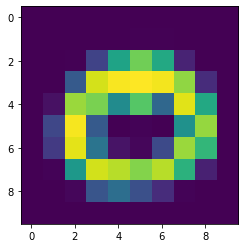

In [47]:
target = 0
im, _ = getRandX(mnist, target, shape=shape)
plt.imshow(im.reshape(10,10))

In [59]:
col = np.zeros((10,10,100))
for i in range(10):
    for j in range(10):
        k = np.random.choice(100, 40, replace=False)
        col[i,j,k] = 1

In [ ]:
85 percent of the input space are connectable by columns
input space 625
potential pool 531
connected (above 0.1) 275

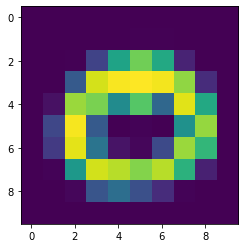

In [80]:
plt.imshow(im.reshape(10,10))

In [86]:
in_sh = (10, 10)
dim = in_sh[0]*in_sh[1]
in_sp = np.zeros(in_sh)
pot_spc = 0.85
conn_thr = 0.1

perm = np.zeros((in_sh[0], in_sh[1], dim))

for i in range(in_sh[0]):
    for j in range(in_sh[1]):
        perm[i,j,:] = np.random.uniform(0, 1, dim)
        not_connected = np.random.choice(dim, 15, replace=False)
        perm[i,j,not_connected] = np.nan

os = np.zeros(in_sh)
for i in range(in_sh[0]):
    for j in range(in_sh[1]):
        os[i,j] = np.nansum(im.flatten() * perm[i,j,:].flatten())
        

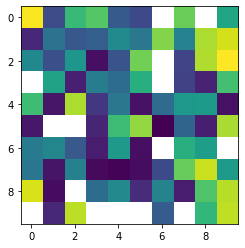

In [87]:
plt.imshow(perm[0,0,:].reshape(10,10))

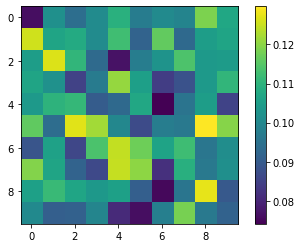

In [89]:
plt.imshow(os)
plt.colorbar()

(array([ 4.,  3.,  6.,  8., 17., 16., 13., 14.,  8.,  6.,  3.,  0.,  2.]),
 array([0.06305556, 0.06904457, 0.07503358, 0.08102259, 0.0870116 ,
        0.09300061, 0.09898962, 0.10497863, 0.11096764, 0.11695665,
        0.12294567, 0.12893468, 0.13492369, 0.1409127 ]),
 <a list of 13 Patch objects>)

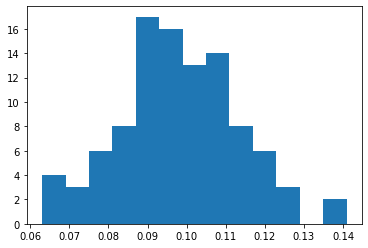

In [71]:
plt.hist(os.flatten(),13)

# todo:
- Jeff Hinton said: "gradient descent was the biggest mistake we made...".
- No "God view" of the nework (as there is in SGD-optimized nets)
- convolutional layer at the top of the network
- training on different examples
- jitter and translations, rotations, scaling during training
- multiple layers + compositionality
- unlearning bad representations
- in the forward mode, every error (negative reinforcement) decreases LTP, and slowly makes a neuron's weights trainable
- 



# Fovea

In [148]:
cone_density = 1 #(per um2)
r_fovea = 0.175e3 #(radius of the fovea, um)
s_fovea_um = np.pi*r_fovea**2
n_cones_in_fovea = cone_density*s_fovea_um
print('Approx. num. of cones in the fovea: {:.0f}'.format(n_cones_in_fovea))
va = 1.1 # visual angle of the fovea, deg.
d = 0.3 # meteres
r = np.tan(np.deg2rad(va))*d
print('Radius of acutely resolved objects at a distance of {:.2f} cm is {:.2f} cm'.format(d*100, r*100))


Approx. num. of cones in the fovea: 96211
Radius of acutely resolved objects at a distance of 30.00 cm is 0.58 cm


# TESTING (TRAIN FIRST before running these cells)

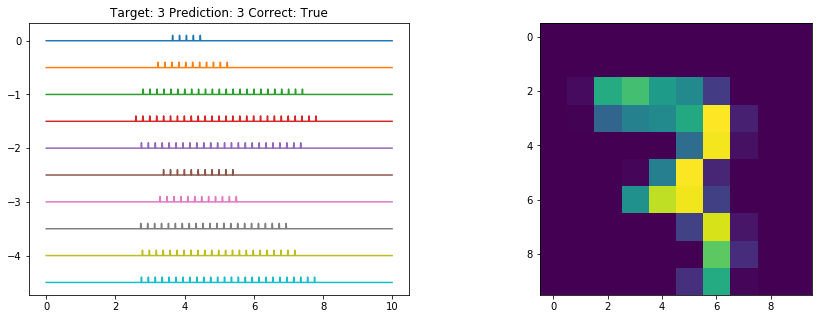

In [305]:
target = 3

im, _ = getRandX(mnist, target, shape=shape)
ST = im2ST(im, desired_nspikes_per_input)
activated_spike_trains = [getV(dt, tau, st) for st in ST]

out = n.fwd(activated_spike_trains)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(10):
    plt.plot(times, 0.1*out[i,:]-0.5*i)
prediction = np.argmax(np.sum(out, axis=1))
plt.title('Target: {} Prediction: {} Correct: {}'.format(target, prediction, target==prediction))

plt.subplot(1,2,2)
plt.imshow(im.reshape(shape))

In [41]:
T = np.zeros((10,100))
for target in range(10):
    print(target)
    for iteration in range(100):
        im, _ = getRandX(mnist, target, shape=shape)
        im = filt(im, w, pool=(2,2))
        ST = im2ST(im, desired_nspikes_per_input)
        activated_spike_trains = [getV(dt, tau, st) for st in ST]
        out = n.fwd(activated_spike_trains)
        prediction = np.argmax(np.sum(out, axis=1))
        T[target, iteration] = 1 if prediction==target else 0

np.mean(T, axis=1)

0
1
2
3
4
5
6
7
8
9


array([0.84, 0.  , 0.33, 0.  , 0.04, 0.12, 0.  , 0.03, 0.32, 0.  ])

In [128]:
im.shape

(100,)

In [3]:

w0 = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
w2 = np.array([[0,0,0],[1,1,1],[0,0,0]])
w3 = np.array([[0,1,0],[0,1,0],[0,1,0]])

w = [w0, w1, w2, w3]

In [8]:
from scipy.signal import convolve2d as conv2d
from skimage.measure import block_reduce as MaxPooling2D
    
def filt(im, w, pool=(2,2)):
    out = []
    for i in range(len(w)):
        out_ = MaxPooling2D(conv2d(im.reshape(10,10), w[i], boundary='symm', mode='same'), pool, np.max)
#         out_ = conv2d(im.reshape(10,10), w[i], boundary='symm', mode='same')
        out.append(out_.flatten())
    return np.hstack(out)

im0, _ = getRandX(mnist, target, shape=shape)
filt(im0, w, pool=(2,2)).shape

(100,)

# TRAINING

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import signal
from scipy.stats import norm
from scipy.special import softmax
from scipy.ndimage.filters import gaussian_filter1d as gauss
from sklearn.metrics import auc
from sklearn.preprocessing import minmax_scale
from sklearn.datasets import fetch_mldata

def plot_digits(mnist, target, shape=(10,10)):
    plt.figure(figsize=(10,7))
    plt.subplot(4,2,1)
    im, choice = getRandX(mnist, target, shape=shape)
    plt.imshow(np.tile(im, (20,1)))
    plt.title('Target: {}, Choice: {}'.format(target, choice))
    plt.subplot(4,2,2)
    plt.imshow(im.reshape(shape))
    plt.subplot(4,2,3)
    im, choice = getRandX(mnist, target, shape=shape)
    plt.imshow(np.tile(im, (20,1)))
    plt.title('Target: {}, Choice: {}'.format(target, choice))
    plt.subplot(4,2,4)
    plt.imshow(im.reshape(shape))
    plt.tight_layout()
    
def getRandX(mnist, target, shape=(10,10)):
    while True:
        choice = np.random.choice(np.arange(0, len(mnist['target']), 1))
        if mnist['target'][choice] == target:
            break
    im = mnist['data'][choice].reshape(28,28)
    im = cv2.resize(im, shape, interpolation = cv2.INTER_AREA)
    im = im/np.max(im)
    im = im.flatten()
    im = im/len(im)
    return im, choice

def times2spiketrain(times, spike_times):
    return signal.unit_impulse(len(times), np.nonzero(np.isin(times,spike_times))[0].tolist())

def get_rnd_strain(times, mu, sd, count):
    return times2spiketrain(times, np.round(np.random.normal(loc=mu, scale=sd, size=count), 2))

def getV(dt, tau, spike_train):
    V = [0]
    for activity in spike_train:
        dV = dt/tau*(-V[-1] + activity)
        V.append(V[-1] + dV)
    return np.array(V[:-1]).flatten() * tau * srate

def norm_gauss(out, ker_len_s, norm=True):
    gg = gauss(out, ker_len_s)
    if norm==False:
        return gg
    if norm==True:
        if np.max(gg)==0:
            return gg
        else:
            return gg/np.max(gg)

def checkIfRightNeuronIsWinning(times, out, target, n):
    overlap = out * norm_gauss(times2spiketrain(times, np.round(np.arange(2, 4, dt),2)), ker_len_s)
    test = np.zeros(out.shape[0])
    for i in range(out.shape[0]):
        test[i] = auc(times, overlap[i,:])
    for i in np.nonzero(n.LTP[n.LTP > promotion_to_LTP]): # we make the activations small so they don't always come out the highest after they are LTP'd
        test[i] = -1
    if np.argmax(test)==target:
        return True, test
    else:
        return False, test

def get_inhibitory_wts(test, n_neurons):
    Wi = minmax_scale(test, feature_range=(0.001, 1), axis=0, copy=True)
    Wi = np.tile(Wi, (n_neurons,1))
    np.fill_diagonal(Wi, 0, wrap=False)
    return Wi

def im2ST(im, desired_nspikes_per_input):
    im = minmax_scale(im, feature_range=(0, desired_nspikes_per_input), copy=True)
    return [get_rnd_strain(times, mu=3, sd=0.75, count=int(im[i])) for i in range(len(im))]


class net():
    def __init__(self, n_neurons=3, in_size=3, lrate=0.01, threshold=1.6):
        self.lrate = lrate
        self.n_neurons = n_neurons
        self.in_size = in_size
        self.W = np.zeros((n_neurons, in_size))
        self.weighted_inputs = []
        self.r = np.nan
        self.srate = 100
        self.threshold = threshold
        self.refractory_period = 0.2
        self.fitness = []
        self.target = []
        self.target_range = []
        self.LTP = np.zeros((n_neurons,))
           
    def fwd(self, list_of_activations):
        self.fitness = []
        self.AUC = []
        self.E = []
        SS = []
        for neuron in range(self.W.shape[0]):
            ss = np.dot(self.W[neuron,:], np.vstack(list_of_activations))
#             ss += self.inhibitory_activations[neuron,:]
            self.weighted_inputs.append(np.copy(ss))
            i = 0
            while i < len(ss):
                if ss[i] > self.threshold:
                    ss[i] = 1
                    ss[(i+1):(i+int(self.refractory_period * self.srate))] = 0
                    i += int(self.refractory_period * self.srate)
                else:
                    ss[i] = 0
                    i += 1
            SS.append(ss)
            self.fitness.append(auc(times, norm_gauss(ss, ker_len_s) * norm_gauss(self.r, ker_len_s, norm=False)))
            self.AUC.append([])
            for syn in range(self.in_size):
                e = norm_gauss(self.r, ker_len_s, norm=False) * list_of_activations[syn] # is how well the reward overlaps with the inputs
                self.AUC[neuron].append(auc(times, e))
        return np.stack(SS)
    
    def optimize(self, test, promotion_to_LTP):
        I = np.ones((self.n_neurons, self.n_neurons))
        inhInp = np.ones((self.n_neurons,self.n_neurons)).dot(test)
        winner = np.argmax(test - inhInp/self.n_neurons)
        mask = np.zeros((10,1))
        mask[winner, 0] = 1
        LTPd = np.ones((self.n_neurons, 1))
        LTPd[np.nonzero(self.LTP > promotion_to_LTP)[0], 0] = 0
        print(np.hstack([mask, LTPd]))
     
        
        self.W += LTPd * mask * self.lrate
        self.W += LTPd * mask * (minmax_scale(np.stack(self.AUC), (0,1), axis=1) - self.W)
        self.W[self.W>1]=1
        self.W[self.W<0]=0

    def randomize_weights(self, promotion_to_LTP=10):
        to_be_randomized = np.nonzero(self.LTP <= promotion_to_LTP)[0]
        self.LTP[to_be_randomized] *= 0
        for i in to_be_randomized:
            self.W[i,:] = np.random.dirichlet(np.ones(self.in_size),size=1) * self.n_neurons


In [10]:
srate = 100
T = 10
dt = 1/srate
times = np.round(np.arange(0,T, dt), 2)

threshold = 12
tau = 3
refractory_period = 0.2
ker_len_s = np.round(0.1/dt, 2)
n_neurons = 10
in_size = 100
desired_nspikes_per_input = 10
promotion_to_LTP = 20


rew_onset = 2
rew_offset = 4

EPOCHS = 140
LRATE = 0.01

n = net(n_neurons=n_neurons, in_size=in_size, lrate=LRATE, threshold=threshold)
n.randomize_weights(promotion_to_LTP)

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


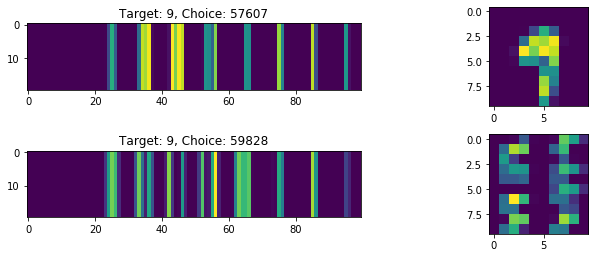

In [38]:
target = 9
shape = (10,10)

mnist = fetch_mldata('MNIST original')

plot_digits(mnist, target, shape=shape)

im, _ = getRandX(mnist, target, shape=shape)

im = filt(im, w, pool=(2,2))

plt.imshow(im.reshape(10,10))

ST = im2ST(im, desired_nspikes_per_input)
activated_spike_trains = [getV(dt, tau, st) for st in ST]

n.r = np.zeros(len(times))


out = n.fwd(activated_spike_trains)
out_ = np.copy(out)



t = time()
fitness = []
D = []
TEST = np.zeros((EPOCHS, n_neurons))

In [39]:
for i in range(EPOCHS):
    out = n.fwd(activated_spike_trains)
    fitness.append(n.fitness)
    right_winner, test = checkIfRightNeuronIsWinning(times, out, target, n)
    TEST[i, :] = test
    if right_winner==True:
        D.append(1)
        n.r = times2spiketrain(times, np.round(np.arange(rew_onset, rew_offset, dt), 2))
        n.optimize(test.reshape(-1,1), promotion_to_LTP)
        n.LTP[np.argmax(test)] += 1
        if n.LTP[np.argmax(test)] > promotion_to_LTP:
            print('LTP achieved on neuron: {}'.format(np.argmax(test)))
            break
        print('EPOCH: {}, optimizing'.format(i))
    else:
        n.randomize_weights(promotion_to_LTP)
        D.append(0)
#         n.inhibitory_activations = np.zeros((n_neurons, len(times)))
print('Runtime: {:.2f} s'.format(time()-t))
        

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
EPOCH: 0, optimizing
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
EPOCH: 1, optimizing
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
EPOCH: 2, optimizing
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
EPOCH: 3, optimizing
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
EPOCH: 4, optimizing
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
EPOCH: 5, optimizing
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
EPOCH: 6, optimizing
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
EPOCH: 7, optimizing
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
EPOCH: 8, opt

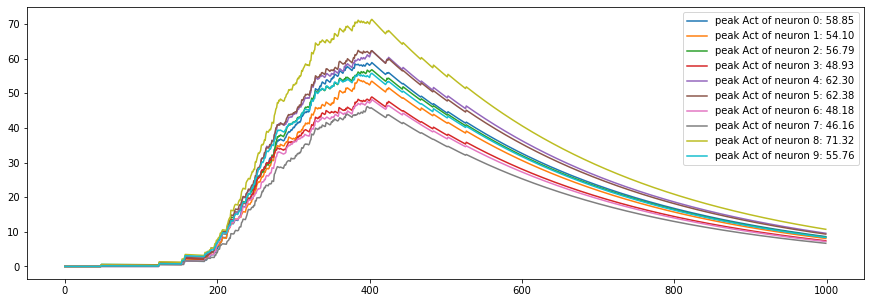

In [40]:
plt.figure(figsize=(15,5))
a = n.W.dot(np.vstack(activated_spike_trains))
for i in range(n_neurons):
    plt.plot(a[i,:], label='peak Act of neuron {}: {:.2f}'.format(i, np.max(a[i,:])))
plt.legend()

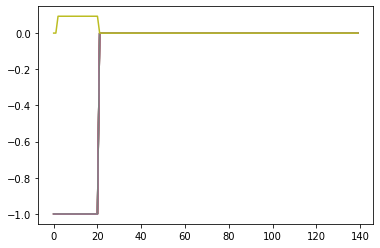

In [302]:
for i in range(1,10):
    plt.plot(TEST[:,i])

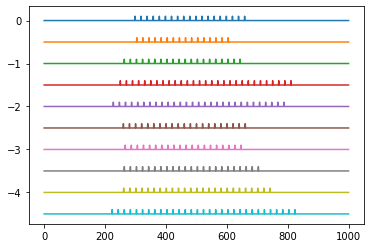

In [303]:
for i in range(10):
    plt.plot(0.1*out[i,:]-i*0.5)

In [250]:
n.LTP

array([21., 21., 21., 21., 21., 21., 21., 21., 21., 21.])

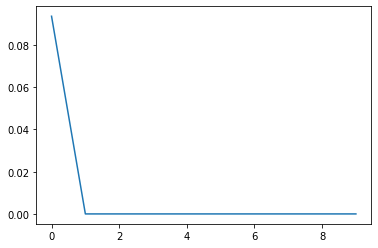

In [18]:
plt.plot(test)

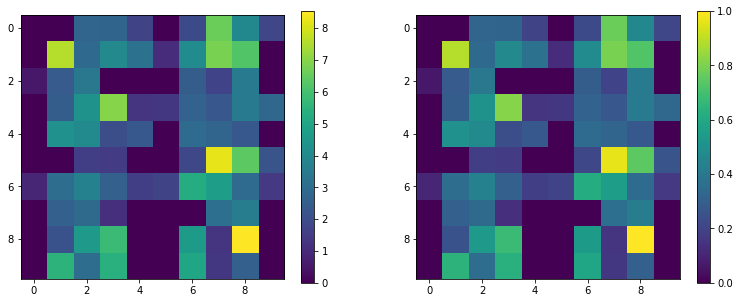

In [165]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(np.stack(n.AUC)[target,:].reshape(10,10))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(n.W[target,:].reshape(10,10))
plt.colorbar()

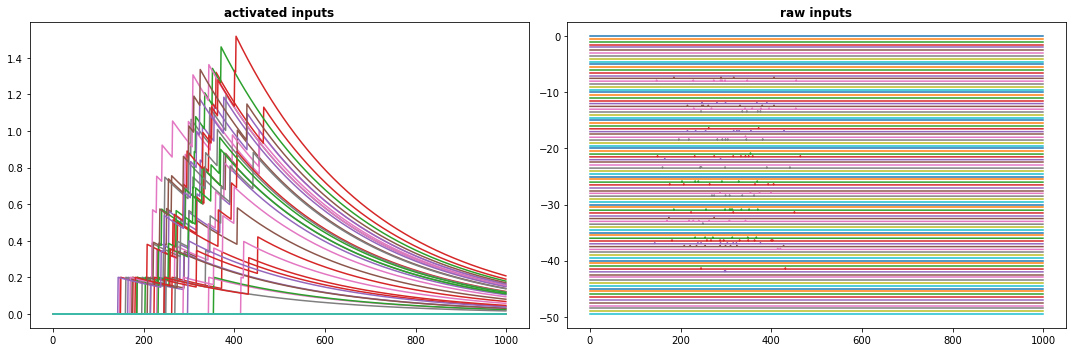

In [20]:
plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
#     plt.plot(np.array(n.AUC[i])- i*0.5)
for i in range(100):
    ax0.plot(np.array(activated_spike_trains[i])*0.2)
    ax1.plot(np.array(ST[i])*0.2 - i*0.5)
ax0.set_title('activated inputs', weight='bold')
ax1.set_title('raw inputs', weight='bold')
plt.tight_layout()

In [261]:
# col = ['blue', 'red', 'black', 'cyan', 'magenta', 'yellow', 'green', 'orange', 'purple', 'black', 'pink', 'brown']
# plt.figure(figsize=(15,2))
# for i in range(n_neurons):
#     plt.plot(times, 0.3*out_[i]-i, alpha=0.2, c=col[i])
#     plt.plot(times, 0.3*out[i]-i, c=col[i])
# plt.tight_layout()    
    
# plt.figure(figsize=(15,8))
# for neuron in range(n_neurons):
#     plt.subplot(n_neurons,1,neuron+1)
#     plt.plot(times, norm_gauss(out[neuron,:], ker_len_s))
#     plt.plot(times, n.weighted_inputs[neuron], c=col[neuron])
#     plt.plot(times, norm_gauss(n.r, ker_len_s), label='dopamine')
#     for syn in range(in_size):
#         plt.plot(times, activated_spike_trains[syn], alpha=0.2, c=col[syn])
#         plt.fill_between(times, 
#                      n.E[neuron][syn] * norm_gauss(out[neuron,:], ker_len_s),
#                      alpha=0.2, label='e_AUC on syn {} is {:.2f}, w: {:.2f}'.format(syn, n.AUC[neuron][syn], n.W[neuron,syn]))
#     plt.legend()
#     plt.plot(times, -0.2 * out[neuron,:], c=col[neuron])
#     plt.axhline(n.threshold, linewidth=1, linestyle='dotted')
#     trg = 'TARGET' if neuron==target else ''
#     f_w = 'bold' if neuron==target else 'normal'
#     plt.title('Neuron: {}, Fitness: {:.3f} {}'.format(neuron, n.fitness[neuron], trg), weight=f_w)
# plt.tight_layout()

# plt.figure(figsize=(15,2))

# fitness_ = np.stack(fitness).T
# for neuron in range(n_neurons):
#     plt.plot(fitness_[neuron,:], label='neuron {}'.format(neuron))
# plt.title('Fitness')
# plt.xlabel('epoch')
# plt.plot(D, linewidth=3, label='dopamine')
# plt.legend()
# plt.tight_layout()

# plt.figure(figsize=(15,2))
# for neuron in range(n_neurons):
#     plt.plot(times, n.inhibitory_activations[neuron,:], label='Inhibitory inputs received by neuron {}'.format(neuron))
# plt.legend()
# plt.tight_layout()

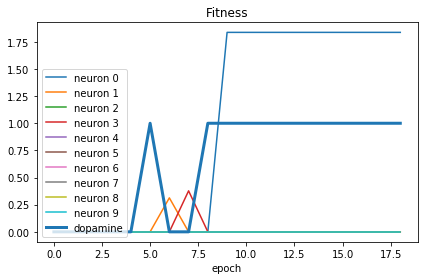

In [21]:
fitness_ = np.stack(fitness).T
for neuron in range(n_neurons):
    plt.plot(fitness_[neuron,:], label='neuron {}'.format(neuron))
plt.title('Fitness')
plt.xlabel('epoch')
plt.plot(D, linewidth=3, label='dopamine')
plt.legend(loc='lower left')
plt.tight_layout()

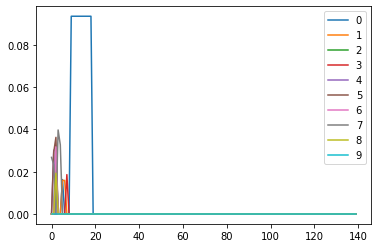

In [22]:
for i in range(n_neurons):
    plt.plot(TEST[:,i], label=i)
plt.legend()

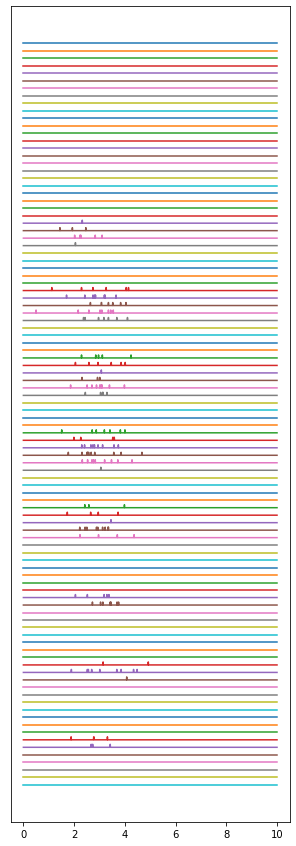

In [90]:
ST = im2ST(im, desired_nspikes_per_input)
plt.figure(figsize=(5,15))
for i in range(len(ST)):
    plt.plot(times, 0.2*ST[i]-i*0.5)
    ax = plt.gca()
    ax.get_yaxis().set_ticks([]) 


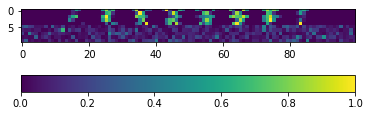

In [62]:
plt.figure
plt.imshow(n.W)
plt.colorbar(orientation="horizontal")

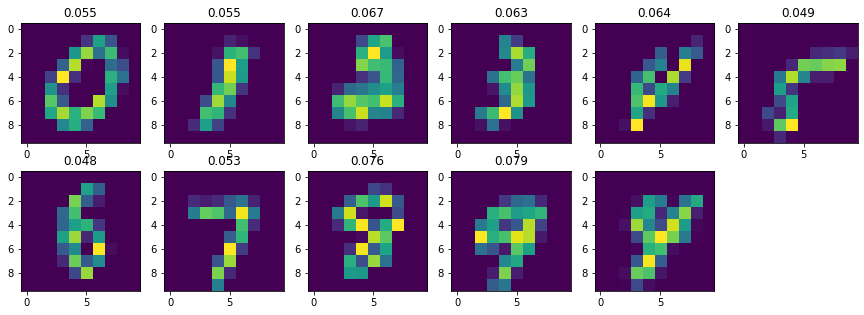

In [150]:
ww = []
for i in range(10):
    ww.append(n.W[i,:].reshape(10,10))

plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2,6,i+1)
    plt.imshow(ww[i])
    plt.title('{:.3f}'.format(np.sum(ww[i] * im.reshape(10,10))))
plt.subplot(2,6,i+2)
plt.imshow(im.reshape(10,10))
    

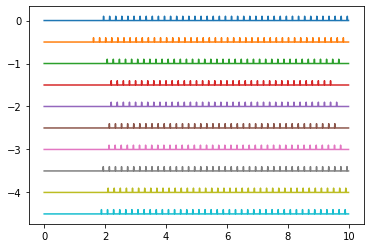

In [40]:
addr = 11000
im = mnist['data'][addr].reshape(28,28)
target = int(mnist['target'][addr])
im = cv2.resize(im, (10,10), interpolation = cv2.INTER_AREA)
im = im/np.max(im)
im = im.flatten()

for i in range(10):
    plt.plot(times, 0.1*out[i,:]-0.5*i)

In [47]:
minmax_scale(-inhInp, (0,1), axis=0)

array([[0.        ],
       [1.        ],
       [0.80487805]])

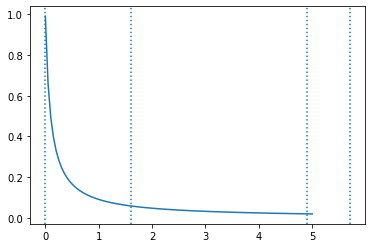

In [123]:
asympt = 1
x = np.linspace(0+0.001, 5, 100)
y1 = 1/(10*x+asympt)
plt.plot(x, y1)
plt.axvline(0, linestyle='dotted')
for i in range(3):
    plt.axvline(inhInp[i], linestyle='dotted')

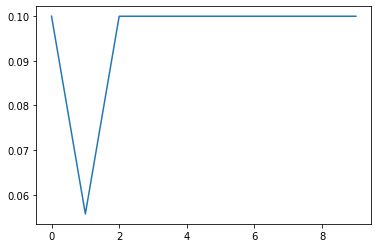

In [248]:
plt.plot(np.mean(n.W, axis=1))